In [1]:
!pip install scikit-learn pandas numpy matplotlib
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 113.1 MB/s eta 0:00:00


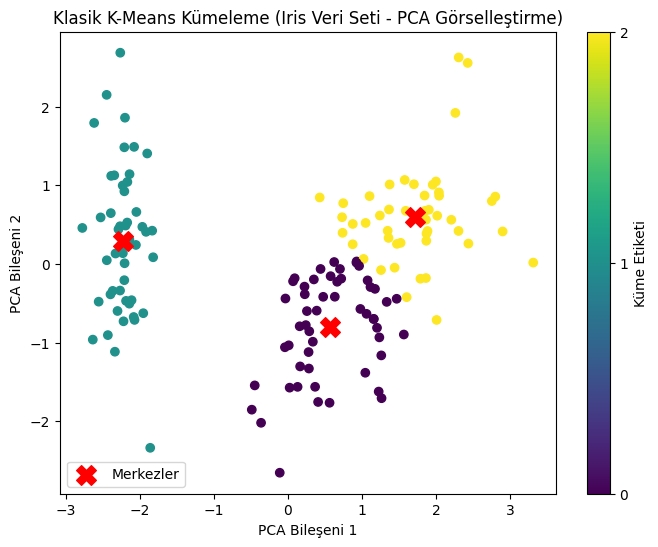

Klasik K-Means Siluet Skoru: 0.460


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 1. Veri Yükleme ve Hazırlık
iris = load_iris()
X = iris.data
n_clusters = 3

# Özellik Ölçeklendirme (Çok Önemli!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Klasik K-Means Uygulaması (K=3)
kmeans_classic = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_classic = kmeans_classic.fit_predict(X_scaled)
classic_silhouette = silhouette_score(X_scaled, labels_classic)

# 3. PCA Uygulama ve Görselleştirme
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Merkezi 4D'den 2D PCA uzayına dönüştürme
centers_classic_4d = kmeans_classic.cluster_centers_
centers_pca = pca.transform(centers_classic_4d)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_classic, cmap='viridis', marker='o')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Merkezler')
plt.title('Klasik K-Means Kümeleme (Iris Veri Seti - PCA Görselleştirme)')
plt.xlabel('PCA Bileşeni 1')
plt.ylabel('PCA Bileşeni 2')
plt.legend()
plt.colorbar(scatter, ticks=range(n_clusters), label='Küme Etiketi')
plt.show()

print(f"Klasik K-Means Siluet Skoru: {classic_silhouette:.3f}")
# Global olarak saklayalım, Kuantum kodunda kullanacağız
global X_scaled_global, X_pca_global, classic_silhouette_global
X_scaled_global = X_scaled
X_pca_global = X_pca
classic_silhouette_global = classic_silhouette

Kuantum Çekirdek Matrisi Hesaplandı. Boyut: (150, 150)


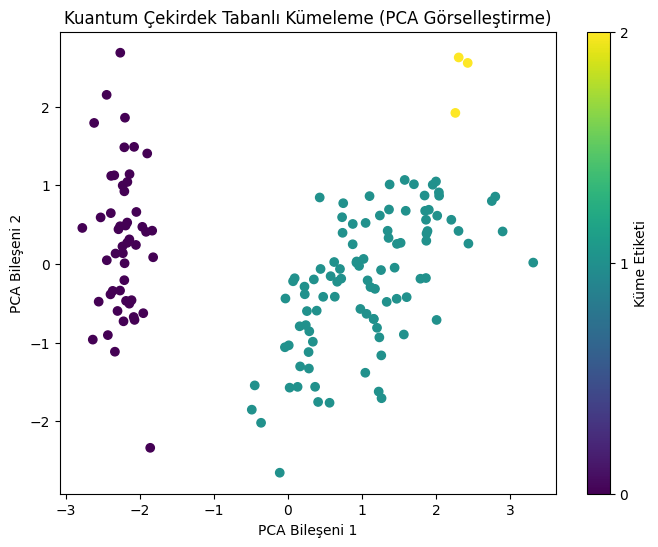

Kuantum Kümeleme Siluet Skoru: 0.480


In [10]:
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

# Önceki hücreden global değişkenleri alıyoruz
X_scaled = X_scaled_global
X_pca = X_pca_global
classic_silhouette = classic_silhouette_global
n_clusters = 3 # 3 küme

# --- KUANTUM KISIM: Çekirdek Fonksiyonu Tanımlama ---
n_qubits = X_scaled.shape[1] # 4 özellik = 4 kübit
dev = qml.device("default.qubit", wires=n_qubits)

def get_overlap_kernel(X):
    """Kuantum çekirdek matrisini (benzerlik matrisi) hesapla."""
    n_samples = X.shape[0]
    kernel_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i, n_samples):
            # QNode tanımı
            @qml.qnode(dev, interface="autograd")
            def overlap_qnode():
                # x_i'yi kodla
                qml.AngleEmbedding(X[i], wires=range(n_qubits))
                # x_j'yi ters kodla
                qml.adjoint(qml.AngleEmbedding)(X[j], wires=range(n_qubits))
                return qml.probs(wires=range(n_qubits))

            prob_0 = overlap_qnode()[0] # |0...0> durumunun olasılığı
            kernel_matrix[i, j] = prob_0
            kernel_matrix[j, i] = prob_0

    return kernel_matrix

# 1. Kuantum Çekirdek Matrisi Hesaplama
kernel_matrix = get_overlap_kernel(X_scaled)
print("Kuantum Çekirdek Matrisi Hesaplandı. Boyut:", kernel_matrix.shape)

# 2. Klasik Çekirdek Tabanlı Kümeleme Uygulaması
# Çekirdek Matrisi Uzaklık Matrisine Dönüştürme: D = 1 - K
distance_matrix = 1 - kernel_matrix

agglo = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='average'
)
labels_quantum = agglo.fit_predict(distance_matrix)
quantum_silhouette = silhouette_score(X_scaled, labels_quantum)

# 3. Sonuçları Görselleştirme (PCA'dan alınan X_pca kullanılarak)
plt.figure(figsize=(8, 6))
scatter_quantum = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_quantum, cmap='viridis', marker='o')
plt.title('Kuantum Çekirdek Tabanlı Kümeleme (PCA Görselleştirme)')
plt.xlabel('PCA Bileşeni 1')
plt.ylabel('PCA Bileşeni 2')
plt.colorbar(scatter_quantum, ticks=range(n_clusters), label='Küme Etiketi')
plt.show()

print(f"Kuantum Kümeleme Siluet Skoru: {quantum_silhouette:.3f}")